<a href="https://colab.research.google.com/github/Eminent01/AMMI-RL/blob/main/Copy_of_Catherine_Monoue_Tabular_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning in Finite MDPs

In [ ]:
#@title Cloning some utilities from github
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git pull

Already up to date.


In [ ]:
#@title Imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import time
import numpy as np
from gym import utils
sys.path.insert(0, './mvarl_hands_on/utils')

# **[Exercice 1]** Understanding Value-Function and Q-function

In this exercice, we are going to learn:

*   What is a MDP?
*   How to evaluate the quality of a policy in a MDP (Value-iteration and Policy-Iteration)
*   How to move from V-function to Q-function
*   How to move from Q-function to greedy-policy



## **[Step 1]** Dealing with MDP and RL environment

Here, we are going to use the cleaning robot MDP from
http://www.incompleteideas.net/sutton/book/first/3/node7.html

In [ ]:
# @title **[Skip]** Robot MDP implementation

class RobotEnv:
    """
    Enviroment with 2 states and 3 actions
    Args:
        gamma (float): discount factor
        seed    (int): Random number generator seed
    """

    def __init__(self, gamma=0.5, seed=42):
        # Set seed
        self._RS = np.random.RandomState(seed)

        # Transition probabilities
        # shape (Ns, Na, Ns)
        # P[s, a, s'] = Prob(S_{t+1}=s'| S_t = s, A_t = a)

        self._Ns = 2
        self._Na = 3
        self._gamma = gamma
        
        # Note we add a recharge option in state A with a negative reward (to have a well defined matrix-transition)
        self._P = np.array([[[1, 0], [3/4, 1/4], [1, 0]], [[0,1],[1,0], [1,0]]])
        self._R = np.array([[0,1,-0.5], [0, -1, 0]])

        self._state_decoder  = {0: "High", 1: "Low"}
        self._action_decoder = {0: "WAIT", 1: "SEARCH", 2: "RECHARGE"}
        
        # Initialize base class
        self._states = np.arange(self.Ns).tolist()
        self._action_sets = [np.arange(self.Na).tolist()]*self.Ns

    ### Utils
    def render_state(self, state):
      return self._state_decoder[state]

    def render_action(self, action):
      return self._action_decoder[action] 

    def render_policy(self, policy):
      if len(np.array(policy).shape) > 1:
        policy = densify_policy(policy)

      txt = ""
      for i, a in enumerate(policy):
        txt += "In state {} perform {}\n".format(self._state_decoder[i], self._action_decoder[a])
      return txt[:-1]

    ### MDP properties
    @property
    def states(self):
      return self._states 

    @property
    def actions(self):
      return self._action_sets 

    @property
    def transition_matrix(self):
      return self._P

    @property
    def reward_matrix(self):
      return self._R
    
    @property
    def gamma(self):
      return self._gamma

    @property
    def Ns(self):
      return self._Ns

    @property
    def Na(self):
      return self._Na

    ### Interact with environment
    def reward_func(self, state, action, *_):
      return self._R[state, action]

    def sample_transition(self, s, a):
        prob = self._P[s,a,:]
        next_s = self._RS.choice(self.states, p = prob)
        return next_s

    def reset(self, new_initial_state=0):
        assert new_initial_state < self.Ns
        self.state = new_initial_state
        return self.state

    def step(self, action):
        next_state = self.sample_transition(self.state, action)
        reward = self.reward_func(self.state, action, next_state)
        done = False
        info = {"str" : "In {} do {} arrive at {} get {}".format(
            self._state_decoder[state],
            self._action_decoder[action],
            self._state_decoder[next_state],
            reward )}
        self.state = next_state

        observation = next_state
        return observation, reward, done, info



In [ ]:
# create the environment
env = RobotEnv()

A MDP have is a tuple with ($S$, $A$, $R$, $P$, $\gamma$)
*   $S$ is the state space
*   $A$ is the action space
*   $R$ is the reward function
*   $P$ is the transition kernel. If I am in state $s$, and take the action $a$, what is the probability of moving to state $s'$
*   $\gamma$ is the discount factor, i.e., how far in the future you are looking for rewards (gamma=0 means, you just take immediate reward, gammma=0.9 you look at reward around 10 steps away)

In [ ]:
# Display some of the MDP relevant information

print("Number of states: ", env.Ns, [env.render_state(s) for s in range(env.Ns)])
print("Number of actions: ", env.Na, [env.render_action(a) for a in range(env.Na)])
print("")
print("Set of states:", env.states)
print("Set of available actions per state:", env.actions)
print("")
print("P has shape: ", env.transition_matrix.shape)  # P[s'|s,a] = P[s, a, s'] = env.P[s, a, s']
print("R has shape: ", env.reward_matrix.shape)  
print("discount factor: ", env.gamma)
print("")

Number of states:  2 ['High', 'Low']
Number of actions:  3 ['WAIT', 'SEARCH', 'RECHARGE']

Set of states: [0, 1]
Set of available actions per state: [[0, 1, 2], [0, 1, 2]]

P has shape:  (2, 3, 2)
R has shape:  (2, 3)
discount factor:  0.5



A MDP is a mathematical representation of an environment. Here, we are going to interact with this environment. 

In [ ]:
state=1
action=1
print(f"State {state}: battery is", env.render_state(state))
print(f"Action {action}: robot performs", env.render_action(action))
print(f"Reward at state={state} and action={action}) is", env.reward_func(state,action))

next_state = env.sample_transition(state,action)
print("Next (stochastic) state is", env.render_state(next_state))  # you can keep running this cell colab

State 1: battery is Low
Action 1: robot performs SEARCH
Reward at state=1 and action=1) is -1.0
Next (stochastic) state is High


Finally, we here define a helper to step in the environment. Let's try to follow a random policy by picking a random action $a$ at everytime step $t$.

In [ ]:
# Interact with environment

state = env.reset() # get initial state
print("initial state: ", state, ":", env.render_state(state))

print("")

# Interacting with the environment by tacking random action
print("s:   a:   s':   r:")
for time in range(4):
    action = np.random.randint(env.Na) # Pick random action
    next_state, reward, done, info = env.step(action)
    print(f"{state}    {action}    {next_state}    {reward} \t --> " + info["str"] if "str" in info else "") 
    if done:
        break
    state = next_state
print("")


initial state:  0 : High

s:   a:   s':   r:
0    2    0    -0.5 	 --> In High do RECHARGE arrive at High get -0.5
0    0    0    0.0 	 --> In High do WAIT arrive at High get 0.0
0    1    0    1.0 	 --> In High do SEARCH arrive at High get 1.0
0    1    0    1.0 	 --> In High do SEARCH arrive at High get 1.0



It is also possible to define a deterministic policy which associate an action $a$ for every state $s$

In [ ]:
# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)
print(env.render_policy(policy))

random policy =  [0 0]
In state High perform WAIT
In state Low perform WAIT


### **[Question 1]** Handcrafting the optimal policy 
Hand-craft the optimal policy (High=search, Low=recharge), display it, and interact with the environment for 5 steps


In [ ]:
my_policy = np.array([1,2])

# Interaction loop
state = env.reset() # get initial state
print("initial state: ", state, ":", env.render_state(state))

print("")

# Interacting with the environment by tacking random action
print("s:   a:   s':   r:")
for time in range(5):
    action = my_policy[state] # Pick action according to the policy
    next_state, reward, done, info = env.step(action)
    print(f"{state}    {action}    {next_state}    {reward} \t --> " + info["str"] if "str" in info else "") 
    if done:
        break
    state = next_state
print("")

initial state:  0 : High

s:   a:   s':   r:
0    1    0    1.0 	 --> In High do SEARCH arrive at High get 1.0
0    1    0    1.0 	 --> In High do SEARCH arrive at High get 1.0
0    1    1    1.0 	 --> In High do SEARCH arrive at Low get 1.0
1    2    0    0.0 	 --> In Low do RECHARGE arrive at High get 0.0
0    1    0    1.0 	 --> In High do SEARCH arrive at High get 1.0



From now on, you should have understood how to interact with an environment, and retrieve the MDP information.




------------------------------

## **[Step 2]** Evaluating a policy
In this subsection, we aim at estimating the quality of a predefined policy, i.e, how much reward can I expect if I follow any policy (even if this policy is not optimal)



### Useful functions
In the following exercice, there is a constant back-and-forth between dense and sparse representation of policy. For instance, taking the action $a=2$ may be encoded by:

*   Sparse Represention: a=2
*   Dense Represention: a=[0, 0, 1]

To help you to move from dense and sparse, policy, we provide you those two functions:

In [ ]:
def densify_policy(policy, Na):
  """ Turn a sparse policy into a dense one.
  Ex: [0, 1], Na=2  -> [[1, 0, 0], [0, 1, 0]]
  """

  Ns = len(policy)
  sparse_policy = np.zeros(shape=(Ns, Na))
  for i, a in enumerate(policy):
    sparse_policy[i,a]=1
  return sparse_policy

def sparsify_policy(policy):
  """ Turn a dense determinist policy into a sparse one.
  Ex: [[1, 0, 0], [0, 1, 0]] -> [0, 1]
  """
  return np.array(policy).argmax(axis=1)


### **[Question 2]** Policy Evaluation
Let's start doing things with our policy! Have a look at slide 34, compute the dynamics and rewards given the policy, and solve the linear system on V to evaluate the policy.

First, compute the policy normalized transition/rewards
$$P^{\pi}(s, s') = \sum_a{\pi(s|a)P(s,a,s')}$$
$$R^{\pi}(s) = \sum_a{\pi(s|a)R(s,a)}$$

Then, compute the value function, by solving Bellman equation,
$$V^{\pi} = R^{\pi} + \gamma P^{\pi}V^{\pi}$$

i.e.
$$V^{\pi} = (I - \gamma P^{\pi})^{-1} R^{\pi}$$

In [ ]:
# Policy evaluation (exact)
from typing import *
def build_Ppi_Rpi(my_env, sparse_policy) -> Tuple[np.ndarray, np.ndarray]:

  # Retrieve the environment MDP
  P = my_env.transition_matrix
  R = my_env.reward_matrix
  gamma = my_env.gamma
  

  dense_policy = densify_policy(sparse_policy, Na=env.Na)

  # Compute the dynamics given the policy
  Ppi = np.sum(dense_policy[...,None] * P,axis=1)
  Rpi = np.sum(dense_policy * R,axis=1)
  return Ppi, Rpi

def build_Vpi(Ppi: np.ndarray, 
            Rpi: np.ndarray,
            ) -> np.ndarray:
  # Evaluate the policy 
  Vpi =np.linalg.solve(np.eye(Ppi.shape[0])-env.gamma*Ppi,Rpi) 
  return Vpi

In [ ]:
# Test your code !
sparse_policy = np.array([1, 0])  # sub-optinal policy... on purpose!

print("## pi:")
print(env.render_policy(sparse_policy))

Ppi, Rpi = build_Ppi_Rpi(env, sparse_policy)

print("Ppi", Ppi)
print("Rpi", Rpi)

Vpi = build_Vpi(Ppi, Rpi)

print("Vpi", Vpi)

## pi:
In state High perform SEARCH
In state Low perform WAIT
Ppi [[0.75 0.25]
 [0.   1.  ]]
Rpi [1. 0.]
Vpi [1.6 0. ]


In [ ]:
# Policy evaluation (exact)

# Retrieve the environment MDP
P = env.transition_matrix
R = env.reward_matrix
gamma = env.gamma

# Policy to evaluate
# State A: Search
# State B: Wait
sparse_policy = np.array([1, 0])  # sub-optinal policy... on purpose!
dense_policy = densify_policy(sparse_policy, Na=env.Na)

print("## pi:")
print(env.render_policy(sparse_policy))

# Compute the dynamics given the policy

# Naive implementation
Ppi = ...
Rpi = ...

# Numpy implementation
Ppi = ...
Rpi = ...


# Evaluate the policy
Vpi = ...
print("## Vpi: ", Vpi)


## pi:
In state High perform SEARCH
In state Low perform WAIT
## Vpi:  Ellipsis


### **[Question 2]** Implement the recursive implementation of value evaluation

You want to evaluate the policy by iterating the fixed point equation on V, starting from a randomly initialized V function.

In other words:

To compute the value function
$$V^{\pi} = R^{\pi} + \gamma P^{\pi}V^{\pi}$$

you can use the contractive property of Bellman 
$$V^{\pi}_{k+1} = R^{\pi} + \gamma P^{\pi}V^{\pi}_k$$

In [ ]:
# Compute Value Iteration

# Stopping criterion
# Feel free to use the any valid stopping criterion (max_iteration or inf_norm)
epsilon = 1e-7

# Retrieving Ppr and Rpi using the function you built
Ppi, Rpi = build_Ppi_Rpi(env, sparse_policy)

def build_Vpi_iterative(Ppi: np.ndarray, 
                        Rpi: np.ndarray, 
                        epsilon: float,
                        ) -> np.ndarray:

  # Estimate V (please print v at each iteration k)
  v = np.zeros((Ppi.shape[0],))
  next_v = None

  # for i in range(100):
  #   if next_v is not None:
  #     v = next_v
  #   next_v = Rpi + env.gamma * Ppi @ v

  while (next_v is None) or np.linalg.norm(v-next_v)>= epsilon:
    if next_v is not None:
      v = next_v
    next_v = Rpi + env.gamma * Ppi @ v
     
  return next_v

print(build_Vpi_iterative(Ppi, Rpi, epsilon))

[1.59999997 0.        ]


### **[Question 3]** Turning V-function into Q-function
What is the Q-function for this value function ?

$$Q^{\pi}(s, a) = R(s, a) + \gamma \sum_{s'} P(s, a, s')V^{\pi}(s')$$

In [ ]:
# Compute the Q values
Ppi, Rpi = build_Ppi_Rpi(env, sparse_policy)
Vpi=build_Vpi(Ppi, Rpi)
R= env.reward_matrix
P=env.transition_matrix

Qpi = R + env.gamma * np.sum(P * Vpi[None,None,:], axis=-1)

print("## Qpi:")
print(Qpi)

## Qpi:
[[ 0.8  1.6  0.3]
 [ 0.  -0.2  0.8]]


The Q-function is a useful way to evaluate the policy. Yet, it can also be used to improve the policy! To do so, you can create a new policy by taking the argmax of the Q-function (improvment step). 

What is the next policy?

In [ ]:
# Compute the Q values
Qpi =  R + env.gamma * np.sum(P * Vpi[None,None,:], axis=-1)
print("## Qpi:")
print(Qpi)

# What is the next policy if we perform one step of policy improvment ?
new_policy = np.array(Qpi.argmax(axis=-1))
print("## new pi:")
print(new_policy)
print(env.render_policy(new_policy))

# Compute the value of the NEW policy
new_dense_policy = densify_policy(new_policy, Na=env.Na)
new_Ppi=np.sum(new_dense_policy[...,None] * P,axis=1)
new_Rpi = np.sum(new_dense_policy * R,axis=1)
new_Vpi =build_Vpi_iterative(new_Ppi, new_Rpi, epsilon)
print(new_Vpi)

## Qpi:
[[ 0.8  1.6  0.3]
 [ 0.  -0.2  0.8]]
## new pi:
[1 2]
In state High perform SEARCH
In state Low perform RECHARGE
[1.77777773 0.88888884]


## **[Step 3]** Policy Improvement in MDP

In slide 50-52, we introduced two algorithms to obtain the optimal policy from a sub-optimal one (by using different shade of policy improvment shapes). 

*   **Policy iteration**: From an initial policy, compute its value exactly, then perform one step of greedy policy improvement.
*   **Value iteration**: From an initial policy, compute its value approximately, then perform one step of greedy policy improvement.


In [ ]:
# @title **[Skip]** New Environment


class GridWorldWithPits:
    def __init__(self, grid, txt_map, gamma=0.99, proba_succ=0.95, uniform_trans_proba=0.001, normalize_reward=False):
        self.desc = np.asarray(txt_map, dtype='c')
        self.grid = grid
        self.txt_map = txt_map

        self.action_names = np.array(['right', 'down', 'left', 'up'])

        self.n_rows, self.n_cols = len(self.grid), max(map(len, self.grid))

        # Create a map to translate coordinates [r,c] to scalar index
        # (i.e., state) and vice-versa
        self.normalize_reward = normalize_reward


        self.initial_state = None
        self.coord2state = np.empty_like(self.grid, dtype=np.int)
        self.nb_states = 0
        self.state2coord = []
        for i in range(self.n_rows):
            for j in range(len(self.grid[i])):
                if self.grid[i][j] != 'w':
                    if self.grid[i][j] == 's':
                        self.initial_state = self.nb_states
                    self.coord2state[i, j] = self.nb_states
                    self.nb_states += 1
                    self.state2coord.append([i, j])
                else:
                    self.coord2state[i, j] = -1

        self.P = None
        self.R = None
        self.proba_succ = proba_succ
        self.uniform_trans_proba = uniform_trans_proba

        # compute the actions available in each state
        self.state_actions = [range(len(self.action_names)) for _ in range(self.nb_states)]#self.compute_available_actions()
        self.matrix_representation()
        self.lastaction = None
        self.current_step = 0
  
        self._actions = self.state_actions
        self._gamma = gamma


    def matrix_representation(self):
        if self.P is None:
            nstates = self.nb_states
            nactions = max(map(len, self.state_actions))
            self.P = np.inf * np.ones((nstates, nactions, nstates))
            self.R = np.inf * np.ones((nstates, nactions))
            for s in range(nstates):
                r, c = self.state2coord[s]
                for a_idx, action in enumerate(range(len(self.action_names))):
                    self.P[s, a_idx].fill(0.)
                    if self.grid[r][c] == 'g':
                        self.P[s, a_idx, self.initial_state] = 1.
                        self.R[s, a_idx] = 10.
                    else:
                        ns_succ, ns_fail = np.inf, np.inf
                        if action == 0:
                            ns_succ = self.coord2state[r, min(self.n_cols - 1, c + 1)]
                            ns_fail = [self.coord2state[r, max(0, c - 1)],
                            self.coord2state[min(self.n_rows - 1, r + 1), c],
                            self.coord2state[max(0, r - 1), c]
                            ]

                        elif action == 1:
                            ns_succ = self.coord2state[min(self.n_rows - 1, r + 1), c]
                            ns_fail = [self.coord2state[max(0, r - 1), c],
                            self.coord2state[r, max(0, c - 1)],
                            self.coord2state[r, min(self.n_cols - 1, c + 1)]
                            ]
                        elif action == 2:
                            ns_succ = self.coord2state[r, max(0, c - 1)]
                            ns_fail = [self.coord2state[r, min(self.n_cols - 1, c + 1)],
                            self.coord2state[max(0, r - 1), c],
                            self.coord2state[min(self.n_rows - 1, r + 1), c]
                            ]
                        elif action == 3:
                            ns_succ = self.coord2state[max(0, r - 1), c]
                            ns_fail = [self.coord2state[min(self.n_rows - 1, r + 1), c],
                            self.coord2state[r, min(self.n_cols - 1, c + 1)],
                            self.coord2state[r, max(0, c - 1)]
                            ]

                        L = []
                        for el in ns_fail:
                            x, y = self.state2coord[el]
                            if self.grid[x][y] == 'w':
                                L.append(s)
                            else:
                                L.append(el)

                        self.P[s, a_idx, ns_succ] = self.proba_succ
                        for el in L:
                            self.P[s, a_idx, el] += (1. - self.proba_succ)/len(ns_fail)
                        # self.P[s, a_idx] = self.P[s, a_idx] + self.uniform_trans_proba / nstates
                        # self.P[s, a_idx] = self.P[s, a_idx] / np.sum(self.P[s, a_idx])

                        assert np.isclose(self.P[s, a_idx].sum(), 1)

                        if self.grid[r][c] == 'x':
                            self.R[s, a_idx] = -20
                        else:
                            self.R[s, a_idx] = -2

            if self.normalize_reward:
                minr = np.min(self.R)
                maxr = np.max(self.R[np.isfinite(self.R)])
                self.R = (self.R - minr) / (maxr - minr)

            self.d0 = np.zeros((nstates,))
            self.d0[self.initial_state] = 1.

    def compute_available_actions(self):
        # define available actions in each state
        # actions are indexed by: 0=right, 1=down, 2=left, 3=up
        state_actions = []
        for i in range(self.n_rows):
            for j in range(self.n_cols):
                if self.grid[i][j] == 'g':
                    state_actions.append([0])
                elif self.grid[i][j] != 'w':
                    actions = [0, 1, 2, 3]
                    if i == 0:
                        actions.remove(3)
                    if j == self.n_cols - 1:
                        actions.remove(0)
                    if i == self.n_rows - 1:
                        actions.remove(1)
                    if j == 0:
                        actions.remove(2)

                    for a in copy.copy(actions):
                        r, c = i, j
                        if a == 0:
                            c = min(self.n_cols - 1, c + 1)
                        elif a == 1:
                            r = min(self.n_rows - 1, r + 1)
                        elif a == 2:
                            c = max(0, c - 1)
                        else:
                            r = max(0, r - 1)
                        if self.grid[r][c] == 'w':
                            actions.remove(a)

                    state_actions.append(actions)
        return state_actions

    def description(self):
        desc = {
            'name': type(self).__name__
        }
        return desc

    def reward_func(self, state, action, next_state):
        return self.R[state, action]

    def reset(self, s=None):
        self.lastaction = None
        if s is None:
            self.state = self.initial_state
        else:
            self.state = s
        self.current_step = 0
        return self.state

    def step(self, action):
        try:
            action_index = self.state_actions[self.state].index(action)
        except:
            raise ValueError("Action {} cannot be executed in this state {}".format(action, self.state))

        p = self.P[self.state, action_index]
        next_state = np.random.choice(self.nb_states, 1, p=p).item()

        reward = self.R[self.state, action_index]

        self.lastaction = action

        r, c = self.state2coord[self.state]
        done = self.grid[r][c] == 'g'
        self.current_step +=1
        self.state = next_state

        return next_state, reward, done, {}

    def render_state(self, state):

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        r, c = self.state2coord[state]

        def ul(x):
            return "_" if x == " " else x

        if self.grid[r][c] == 'x':
            out[1 + r][2 * c + 1] = utils.colorize(out[1 + r][2 * c + 1], 'red', highlight=True)
        elif self.grid[r][c] == 'g':  # passenger in taxi
            out[1 + r][2 * c + 1] = utils.colorize(ul(out[1 + r][2 * c + 1]), 'green', highlight=True)
        else:
            out[1 + r][2 * c + 1] = utils.colorize(ul(out[1 + r][2 * c + 1]), 'yellow', highlight=True)

        return "\n".join(["".join(row) for row in out]) + "\n"

    def render_action(self, action):
      return self.action_names[action] 

    def render_policy(self, pol):
        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        r, c = self.state2coord[self.state]

        for s in range(self.Ns):
            r, c = self.state2coord[s]
            action = pol[s]
            # 'right', 'down', 'left', 'up'
            if action == 0:
                out[1 + r][2 * c + 1] = '>'
            elif action == 1:
                out[1 + r][2 * c + 1] = 'v'
            elif action == 2:
                out[1 + r][2 * c + 1] = '<'
            elif action == 3:
                out[1 + r][2 * c + 1] = '^'
            else:
                raise ValueError()

        return "\n".join(["".join(row) for row in out]) + "\n"

    def copy(self):
        new_env = GridWorldWithPits(grid=self.grid, txt_map=self.txt_map,
                                    proba_succ=self.proba_succ, uniform_trans_proba=self.uniform_trans_proba)
        return new_env

    def sample_transition(self, s, a):
        try:
            p = self.P[s, a]
        except:
            raise ValueError("Action {} cannot be executed in this state {}".format(action, self.state))
        next_state = np.random.choice(self.nb_states, 1, p=p).item()

    ### MDP properties
    @property
    def states(self):
      return np.zeros([self.n_cols, self.n_rows]) 

    @property
    def actions(self):
      return range(4)

    @property
    def transition_matrix(self):
      return self.P

    @property
    def reward_matrix(self):
      return self.R
    
    @property
    def gamma(self):
      return self._gamma

    @property
    def Ns(self):
      return self.n_cols * self.n_rows

    @property
    def Na(self):
      return 4

The environment works as follow:

*   At each timestep, you have a negative reward of -2
*   If the agent moves to state labelled with X, it receives a negative reward of -20
*   If the agent moves to the state labelled with G (goal), it receives a reward of 10, and the trajectory ends




In [ ]:
#@title New Maze environment
# s: start
# g: goal
# x: negative reward state

grid1 = [
    ['', '', '', 'g'],
    ['', 'x', '', ''],
    ['s', '', '', '']
]
grid1_MAP = [
    "+-------+",
    "| : : :G|",
    "| :x: : |",
    "|S: : : |",
    "+-------+",
]

env = GridWorldWithPits(grid=grid1, txt_map=grid1_MAP, uniform_trans_proba=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
#@title Relevant information about the environment
# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.transition_matrix.shape)  # P[s'|s,a] = P[s, a, s'] = env.P[s, a, s']
print("R has shape: ", env.reward_matrix.shape)  
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=0, a=1,s'=1): ", env.reward_func(0,1,1))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward) 
    if done:
        break
    state = next_state
print("")

Set of states: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Set of actions: range(0, 4)
Number of states:  12
Number of actions:  4
P has shape:  (12, 4, 12)
R has shape:  (12, 4)
discount factor:  0.99

initial state:  8
reward at (s=0, a=1,s'=1):  -2.0

random policy =  [3 1 1 1 1 2 1 1 0 0 2 2]
(s, a, s', r):
8 0 9 -2.0
9 0 10 -2.0
10 2 9 -2.0
9 0 10 -2.0



In [ ]:
#@title Definining and running a random policy
# Define a fixed random policy
sparse_policy = np.random.randint(env.Na, size = (env.Ns,))
print(env.render_policy(sparse_policy))

# Start a new episode
state = env.reset()
print("start:")
print(env.render_state(state))

# Follow the policy
for i in range(3):
    action = sparse_policy[state]
    state, reward, done, _ = env.step(action)
    print(action, ":", env.render_action(action))
    print(env.render_state(state))
    if done:
      break


+-------+
|>:<:v:v|
|v:^:v:v|
|^:>:>:>|
+-------+

start:
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

3 : up
+-------+
| : : :G|
|_:x: : |
|S: : : |
+-------+

1 : down
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

3 : up
+-------+
| : : :G|
|_:x: : |
|S: : : |
+-------+



In [ ]:
#@title Utility functions
# useful function
def plot_infnorm(all_v, v_star,name):
  """Print the infinite norm between computed vs and v_star (to get learning progress)."""
  
  all_v = np.array(all_v)
  v_star = np.array(v_star)

  # Compute inf norm
  diff = np.absolute(all_v - v_star).max(axis=1)

  plt.plot(diff)
  plt.xlabel('Iteration')
  plt.ylabel('Error')
  plt.title(name)



### **[Question 4]** Implement Policy Iteration

+-------+
|<:<:<:<|
|<:<:<:<|
|<:<:<:<|
+-------+

+-------+
|<:<:>:>|
|^:^:^:^|
|v:<:<:<|
+-------+

+-------+
|<:<:>:>|
|^:^:^:^|
|v:<:<:<|
+-------+

+-------+
|<:>:>:>|
|^:>:>:^|
|v:<:^:^|
+-------+

+-------+
|<:>:>:>|
|^:>:>:^|
|v:<:^:^|
+-------+

+-------+
|>:>:>:>|
|^:>:>:^|
|^:>:>:^|
+-------+

+-------+
|>:>:>:>|
|^:>:>:^|
|^:>:>:^|
+-------+

+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+

+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+

+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+

  ###  Final results  ###
+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+



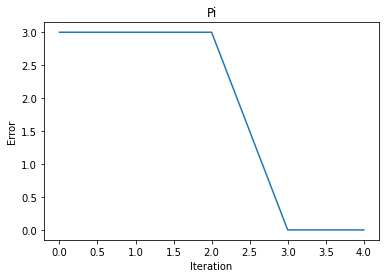

In [ ]:
# Compute Policy Iteration

env.reset()

# Retrieve the environment MDP
P = env.transition_matrix
R = env.reward_matrix
gamma = env.gamma 

# Prepare v, and storage
v_all = []

sparse_policy = np.zeros(shape=(env.Ns,), dtype=np.int32) + 2
sparse_policy_all = []

# iterate over the value
while True:
  
  print(env.render_policy(sparse_policy))

  # Densify policy to perform matrix operation
  dense_policy = densify_policy(sparse_policy, Na=env.Na)

  # Compute v (and intermediate values)

  Ppi = np.sum(dense_policy[...,None] * P,axis=1)
  Rpi = np.sum(dense_policy * R,axis=1)

  Vpi = build_Vpi(Ppi, Rpi)

  # Policy improvement step
  Qpi =  R + gamma * np.sum(P * Vpi[None,None,:], axis=-1)
  new_sparse_policy = Qpi.argmax(axis=1) 

  # store v
  v_all.append(Vpi)
  sparse_policy_all.append(new_sparse_policy)
  print(env.render_policy(new_sparse_policy))

  # stopping criterion 
  if len(sparse_policy_all)>1 and np.linalg.norm(sparse_policy_all[-1]-sparse_policy_all[-2])==0:
  # if len(v_all)>1 and np.linalg.norm(v_all[-1]-v_all[-2])<epsilon : 
    break

  sparse_policy = new_sparse_policy


# Display final results
print("  ###  Final results  ###")
print(env.render_policy(new_sparse_policy))
plot_infnorm(sparse_policy_all, new_sparse_policy,name="Pi")

In [ ]:
# Start a new episode
state = env.reset()
print("start:")
print(env.render_state(state))

# Follow the policy
for i in range(10):
    action = new_sparse_policy[state]
    state, reward, done, _ = env.step(action)
    print(action, ":", env.render_action(action))
    print(env.render_state(state))
    if done:
      break


start:
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

0 : right
+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+

0 : right
+-------+
| : : :G|
| :x: : |
|S: :_: |
+-------+

0 : right
+-------+
| : : :G|
| :x: : |
|S: : :_|
+-------+

3 : up
+-------+
| : : :G|
| :x: :_|
|S: : : |
+-------+

3 : up
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

0 : right
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+



### **[Question 5]** Implement Value Iteration (Optional)

+-------+
|<:<:<:<|
|<:<:<:<|
|<:<:<:<|
+-------+

+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+

+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+

+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+

  ###  Final results  ###
+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+



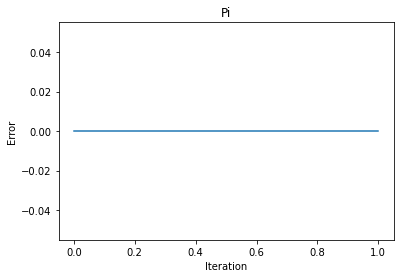

In [ ]:
# compute optimal policy
# Compute Policy Iteration

# Retrieve the environment MDP
P = env.transition_matrix
R = env.reward_matrix
gamma = env.gamma 

# Prepare v, and storage
v = np.zeros(env.Ns)
v_all = []

sparse_policy = np.zeros(shape=(env.Ns,), dtype=np.int32) + 2
sparse_policy_all = []

# iterate over the value
while True:
  
  print(env.render_policy(sparse_policy))

  # Densify policy to perform matrix operation
  dense_policy = densify_policy(sparse_policy, Na=env.Na)

  # Compute v (and intermediate values)

  # Policy improvement step
  Ppi = np.sum(dense_policy[...,None] * P,axis=1)
  Rpi = np.sum(dense_policy * R,axis=1)
  v= Rpi + env.gamma * Ppi @ v

  # Policy improvement step
  Qpi = R + gamma * np.sum(P * Vpi[None,None,:], axis=-1)
  new_sparse_policy = Qpi.argmax(axis=1)

  # store v
  v_all.append(np.copy(v))
  sparse_policy_all.append(np.copy(new_sparse_policy))
  print(env.render_policy(new_sparse_policy))

  # stopping criterion 
  # if all(...): 
  if np.linalg.norm(sparse_policy-new_sparse_policy)==0:
    break

  sparse_policy = new_sparse_policy


# Display final results
print("  ###  Final results  ###")
print(env.render_policy(new_sparse_policy))
plot_infnorm(sparse_policy_all, new_sparse_policy, name="Pi")

# **[Exercice 2]** Q learning
Q learning is a **model-free** algorithm for estimating the optimal Q-function **online**. 

Being **model-free** means that it doesn't assume knowledge of $P$ and $r$, only that we can interact with the environment.

Being **online** means that we update, and hopefully improve our
policy with each step that we are making in the environment.

It is an **off-policy** algorithm. This means that the samples we use to update our **learnt** policy are collected with an **acting**  policy that is (potentially) not the **learnt** one, and not the one associated to the estimated Q-function.

Q-learning works as follows:
- **Initialization**: Initialize a current estimated Q-function $Q$ to $0$. Receive an initial state $s$ from the environment.
- **Iterate**:
  -  Pick an action according to an $\varepsilon$-greedy version of the argmax policy on $Q$, i.e. with probability $\varepsilon$, pick a random uniform action, with probability $1 - \varepsilon$, pick the argmax of $Q(s, a)$.
  - Observe the next state $s'$ and new reward $r$.
  - Update $Q$ using the quadruplet $(s, a, r, s')$ with learning rate $\alpha$
  $$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha (r + \gamma \max\limits_{a'} Q(s', a'))$$

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the cumulative sum of rewards

In [ ]:
# main algorithmic loop
state = env.reset()
t = 0
max_steps = 50000  # Increasee this number when it works for full convergence
all_rewards = []
all_q_function = []

# Training values
epsilon = 0.05
alpha = 0.1

q_function = np.zeros((env.Ns, env.Na))

while t < max_steps:
    
    # Sample the action (epsilon greedy)
    if np.random.uniform()< epsilon:
      action =np.random.randint(env.Na) # uniform sampling
    else:
      action= q_function[state].argmax() # greedy policy
    
    

    # Sample the environment
    next_state, reward, done, info = env.step(action)
    
    # Update q-function
    if done:
      max_next_q = (1-alpha)*q_function[state,action]+ alpha*reward
    else:
      max_next_q =(1-alpha)*q_function[state,action]+ alpha*(reward +env.gamma *  q_function[next_state].max())
        
    q_function[state, action] = max_next_q

    # Store information
    all_rewards.append(reward)
    all_q_function.append(np.copy(q_function))
    
    state = next_state
    if done:
      state = env.reset()
    
    # iterate
    t = t + 1

sparse_policy = q_function.argmax(axis=1)
print(env.render_policy(sparse_policy))

+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:^:^|
+-------+



Text(0, 0.5, 'rewards')

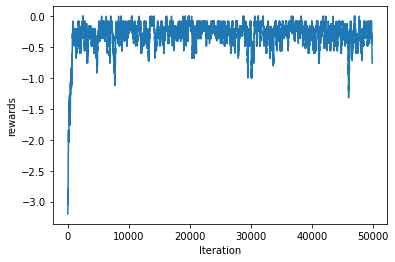

In [ ]:
#@title Plotting evolution of the reward across time
average_rewards = np.convolve(all_rewards, np.ones(150)/150, mode='valid')  # average rewards over 100 steps
plt.figure()
plt.plot(average_rewards)
plt.xlabel('Iteration')
plt.ylabel('rewards')
# Now you have to implement the cumulative rewards :)

Text(0, 0.5, 'q[1, 1]')

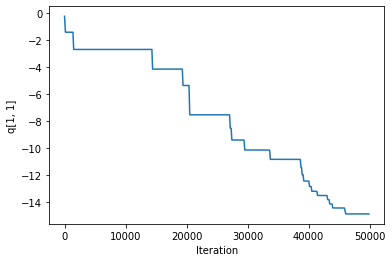

In [ ]:
#@title Plotting evolution of the q value across time
state=1 #@param
action=1 #@param
one_q = [q[state, action] for q in all_q_function]
average_q_values = np.convolve(one_q, np.ones(100)/100, mode='valid')  # average rewards over 100 steps
plt.figure()
plt.plot(average_q_values)
plt.xlabel('Iteration')
plt.ylabel(f'q[{state}, {action}]')
# Now you have to implement the Q error :)

In [ ]:
#@title Running the agent:
state = env.reset()
env.render_state(state)
rewards = []
for i in range(30):
    action = sparse_policy[state]
    print(env.render_action(action))
    state, reward, done, _ = env.step(action)
    if done:
      state = env.reset()
    print(env.render_state(state))

right
+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+

right
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

right
+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+

right
+-------+
| : : :G|
| :x: : |
|S: :_: |
+-------+

up
+-------+
| : : :G|
| :x:_: |
|S: : : |
+-------+

right
+-------+
| : : :G|
| :x: :_|
|S: : : |
+-------+

up
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

right
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

right
+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+

right
+-------+
| : : :G|
| :x: : |
|S: :_: |
+-------+

up
+-------+
| : : :G|
| :x:_: |
|S: : : |
+-------+

right
+-------+
| : : :G|
| :x: :_|
|S: : : |
+-------+

up
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

right
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

right
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

right
+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+

right
+-------+
| : : :G|
| :x: : |
|S: :_: |
+-------+

up
+-------+
| : : :G|
| :x:_: |
|S: : : |


As a next step, we are going to encapsulate the Q-learning information into a class. The idea is to structure the algorithm such as an Q-agent is trained. Therefore, the training loop should be unchanged, you only need to code the QAgent class

In [ ]:
from copy import deepcopy

In [ ]:
# ---------------------------
# Q-Agent
# ---------------------------
class QAgent:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self, env, gamma, learning_rate):
      self.env=env
      self.gamma=gamma
      self.lr=learning_rate
      self.q_function = np.zeros((env.Ns,env.Na))
    
    def sample_action(self, state,greedy=False):
      if greedy:
        action= self.q_function[state].argmax()
      else:
        action =np.random.randint(self.env.Na)
      return action
    
    def update(self, state, action, next_state,reward,done,):
      if done:
        max_next_q = (1-self.lr)*self.q_function[state,action]+ self.lr*reward
      else:
        max_next_q =(1-self.lr)*self.q_function[state,action]+ self.lr*(reward +self.gamma *  self.q_function[next_state].max())
      
      self.q_function[state,action]=max_next_q
      return self.q_function 
      

In [ ]:
# Training:
q_agent = QAgent(env, gamma=env.gamma, learning_rate=1.)


qvalues = []
rewards = []

state = env.reset()
t = 0
max_steps = 1000

# main algorithmic loop
while t < max_steps:
    
    # Sample the action
    action = q_agent.sample_action(state)
    
    # Sample the environment
    observation, reward, done, info = env.step(action)
    
    # Update q-function
    qvalue = q_agent.update(state, action, next_state, reward, done)

    # Store information 
    rewards.append(deepcopy(reward))
    qvalues.append(deepcopy(qvalue))
    
    state = observation
    if done:
        state = env.reset()
    
    # iterate
    t = t + 1


# **[Exercice 3]** SARSA (Optional)
Sarsa is a **model-free** algorithm for estimating the optimal Q-function **online**. 

Being **model-free** means that it doesn't assume knowledge of $P$ and $r$, only that we can interact with the environment.

Being **online** means that we update, and hopefully improve our
policy with each step that we are making in the environment.

It is an **on-policy** algorithm. This means that the samples we use to update our **learnt** policy are collected with an **acting**  policy that is the **learnt** one, i.e. the one associated to the estimated Q-function.

Q-learning works as follows:
- **Initialization**: Initialize a current estimated Q-function $Q$ to $0$. Receive an initial state $s$ from the environment. Pick an action $a$ according to a softmax version of $Q$ with temperature $\tau$, i.e. sample action $a$ with probability 
  $$\pi(a | s) = \frac{\exp \frac{Q(s,a)}{\tau}}{\sum\limits_{a'} \exp \frac{Q(s,a)}{\tau}}.$$

- **Iterate**: 
  - Play action $a$.
  - Observe the next state $s'$ and new reward $r$.
  - Pick an action $a'$ according to a softmax version of $Q$ with temperature $\tau$, i.e. sample action $a$ with probability 
  $$\pi(a' | s') = \frac{\exp \frac{Q(s',a')}{\tau}}{\sum\limits_{a''} \exp \frac{Q(s',a'')}{\tau}}.$$
  - Update $Q$ using the quintuplet $(s, a, r, s', a')$ (thus the name SARSA) with learning rate $\alpha$
  $$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha (r + \gamma Q(s', a'))$$
  - $a \leftarrow a'$.
  - (Optional) Lower the temperature $\tau$.

1. Implement SARSA with softmax (Gibbs) exploration and test the convergence to $Q^\star$
2. Plot the value $\|V_n - V^\star\|_{\infty}$
3. Plot the expected cumulative reward of the algorithms: $t \mapsto \sum_{i=1}^t r_i$

In [ ]:
# ---------------------------
# SARSA
# ---------------------------
import random
class SARSA:
    """
    SARSA with deacreasing epsilon for exploration
    """
    def __init__(self, env, gamma, learning_rate):
      # Start with a random policy
      self.env=env
      self.lr=learning_rate
      self.gamma=gamma
      self.q_function = np.zeros((env.Ns,env.Na))

    def sample_action(self, state, greedy=False):

      if greedy: 
        next_a= self.q_function[state].argmax()
      else:
        pi=np.exp(self.q_function[state])/np.exp(self.q_function[state]).sum()
        next_a =random.choices(np.arange(env.Na), weights=pi)[0]
      return next_a
        
    def update(self, state, action, next_state, next_action, reward,done):
      if done:
        # return self.q_function 
        max_next_q = (1-self.lr)*self.q_function[state,action]+ self.lr*reward
      else:
        max_next_q = (1-self.lr)*self.q_function[state,action]+ self.lr*(reward +self.gamma *  self.q_function[next_state,next_action])

      self.q_function[state,action]=max_next_q
      
      # self.epsilon=self.epsilon/2 # decrease epsilon
      return self.q_function  
      


In [ ]:
from itertools import repeat


sarsa = SARSA(env, gamma=env.gamma, learning_rate=0.7)
state = env.reset()
t = 0

# Learn the optimal policy by interacting with the environment
qvalues = []
rewards = []

state = env.reset()
t = 0
max_steps = 1000

# epsilon_=0.5
# initialize the first action
greedy=False
if greedy :
  action= sarsa.q_function[state].argmax()
else:
  action =np.random.randint(env.Na)

# main algorithmic loop
while t < max_steps:

    # Sample the environment
    # print(f'action,{action},state {state}')
    next_state, reward, done, info = env.step(action)
    
    # Sample the action
    next_action = sarsa.sample_action(next_state)
    
    # Update q-function
    qvalue = sarsa.update(state, action, next_state, next_action, reward,done)

    # Store information 
    rewards.append(reward)
    qvalues.append(deepcopy(qvalue))
    
    action = next_action 
    state= next_state
    if done:
        state = env.reset() 
    # iterate
    t = t + 1
   



Text(0, 0.5, 'q[7, 3]')

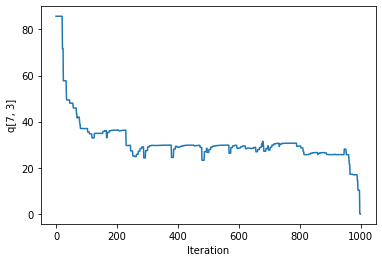

In [ ]:
# Plot the value function error 
error_q_values = [np.linalg.norm(q- qvalues[-1],np.inf) for q in qvalues]
plt.figure()
plt.plot(error_q_values)
plt.xlabel('Iteration')
plt.ylabel(f'q[{state}, {action}]')


Text(0, 0.5, 'q[1, 1]')

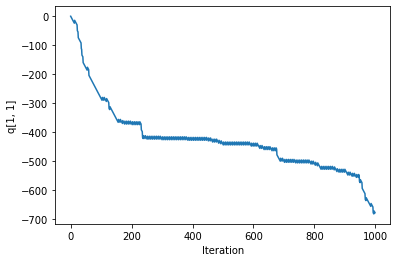

In [ ]:
# Plot the expected return 
state=1 
action=1 
one_q = np.array([sum(rewards[:i]) for i in range(0,len(rewards))])
# error_q_values = np.convolve(one_q, np.ones(100)/100, mode='valid')  # average errors over 100 steps
plt.figure()
plt.plot(one_q)
plt.xlabel('Iteration')
plt.ylabel(f'q[{state}, {action}]')